In [31]:
from pickle import NEXT_BUFFER
# from src/behavior_generation_lecture_python/mdp/mdp.py
import math
from typing import Any, Dict, List, Optional, Set, Tuple, Union

import numpy as np

SIMPLE_MDP_DICT = {
    "states": [1, 2],
    "actions": ["A", "B"],
    "initial_state": 1,
    "terminal_states": [2],
    "transition_probabilities": {
        (1, "A"): [(0.2, 1), (0.8, 2)],
        (1, "B"): [(0.5, 1), (0.5, 2)],
        (2, "A"): [(1.0, 1)],
        (2, "B"): [(0.3, 1), (0.7, 2)],
    },
    "reward": {1: -0.1, 2: -0.5},
}

GRID_MDP_DICT = {
    "grid": [
        [-0.04, -0.04, -0.04, +1],
        [-0.04, None, -0.04, -1],
        [-0.04, -0.04, -0.04, -0.04],
    ],
    "initial_state": (1, 0),
    "terminal_states": {(3, 2), (3, 1)},
    "transition_probabilities_per_action": {
        (0, 1): [(0.8, (0, 1)), (0.1, (1, 0)), (0.1, (-1, 0))],
        (0, -1): [(0.8, (0, -1)), (0.1, (1, 0)), (0.1, (-1, 0))],
        (1, 0): [(0.8, (1, 0)), (0.1, (0, 1)), (0.1, (0, -1))],
        (-1, 0): [(0.8, (-1, 0)), (0.1, (0, 1)), (0.1, (0, -1))],
    },
}

LC_LEFT_ACTION, STAY_IN_LANE_ACTION, LC_RIGHT_ACTION = (1, 1), (1, 0), (1, -1)

HIGHWAY_MDP_DICT = {
    "grid": [
        [0, -1, -1, -1, -1, -1, -1, -1, -1, -50],
        [0, -2, -2, -2, -2, -2, -2, -2, -2, -50],
        [0, -3, -3, -3, -3, -3, -3, -3, -3, -50],
        [None, None, None, None, None, None, -2, -2, -2, 0],
    ],
    "initial_state": (0, 2),
    "terminal_states": {(9, 3), (9, 1), (9, 2), (9, 0)},
    "transition_probabilities_per_action": {
        STAY_IN_LANE_ACTION: [(1.0, STAY_IN_LANE_ACTION)],
        LC_LEFT_ACTION: [(0.5, LC_LEFT_ACTION), (0.5, STAY_IN_LANE_ACTION)],
        LC_RIGHT_ACTION: [(0.75, LC_RIGHT_ACTION), (0.25, STAY_IN_LANE_ACTION)],
    },
    "restrict_actions_to_available_states": True,
}


class MDP:
    def __init__(
        self,
        states: Set[Any],
        actions: Set[Any],
        initial_state: Any,
        terminal_states: Set[Any],
        transition_probabilities: Dict[Tuple[Any, Any], List[Tuple[float, Any]]],
        reward: Dict[Any, float],
    ) -> None:
        """A Markov decision process.

        Args:
            states: Set of states.
            actions: Set of actions.
            initial_state: Initial state.
            terminal_states: Set of terminal states.
            transition_probabilities: Dictionary of transition
                probabilities, mapping from tuple (state, action) to
                list of tuples (probability, next state).
            reward: Dictionary of rewards per state, mapping from state
                to reward.
        """
        self.states = states

        self.actions = actions

        assert initial_state in self.states
        self.initial_state = initial_state

        for terminal_state in terminal_states:
            assert (
                terminal_state in self.states
            ), f"The terminal state {terminal_state} is not in states {states}"
        self.terminal_states = terminal_states

        for state in self.states:
            for action in self.actions:
                if (state, action) not in transition_probabilities:
                    continue
                total_prob = 0
                for prob, next_state in transition_probabilities[(state, action)]:
                    assert (
                        next_state in self.states
                    ), f"next_state={next_state} is not in states={states}"
                    total_prob += prob
                assert math.isclose(total_prob, 1), "Probabilities must add to one"
        self.transition_probabilities = transition_probabilities

        assert set(reward.keys()) == set(
            self.states
        ), "Rewards must be defined for every state in the set of states"
        for state in self.states:
            assert reward[state] is not None
        self.reward = reward

    def get_states(self) -> Set[Any]:
        """Get the set of states."""
        return self.states

    def get_actions(self, state) -> Set[Any]:
        """Get the set of actions available in a certain state, returns [None] for terminal states."""
        if self.is_terminal(state):
            return {None}
        return set(
            [a for a in self.actions if (state, a) in self.transition_probabilities]
        )

    def get_reward(self, state) -> float:
        """Get the reward for a specific state."""
        return self.reward[state]

    def is_terminal(self, state) -> bool:
        """Return whether a state is a terminal state."""
        return state in self.terminal_states

    def get_transitions_with_probabilities(
        self, state, action
    ) -> List[Tuple[float, Any]]:
        """Get the list of transitions with their probability, returns [(0.0, state)] for terminal states."""
        if action is None or self.is_terminal(state):
            return [(0.0, state)]
        return self.transition_probabilities[(state, action)]

    def sample_next_state(self, state, action):
        if self.is_terminal(state):
            return ValueError("No next state for terminal states.")
        if action is None:
            return ValueError("Action must not be None.")
        prob_per_transition = self.get_transitions_with_probabilities(state, action)
        num_actions = len(prob_per_transition)
        choice = np.random.choice(
            num_actions, 1, p=[ppa[0] for ppa in prob_per_transition]
        )
        return prob_per_transition[int(choice)][1]


class GridMDP(MDP):
    def __init__(
        self,
        grid: List[List[Union[float, None]]],
        initial_state: Tuple[int, int],
        terminal_states: Set[Tuple[int, int]],
        transition_probabilities_per_action: Dict[
            Tuple[int, int], List[Tuple[float, Tuple[int, int]]]
        ],
        restrict_actions_to_available_states: Optional[bool] = False,
    ) -> None:
        """A Markov decision process on a grid.

        Args:
            grid: List of lists, containing the rewards of the grid
                states or None.
            initial_state: Initial state in the grid.
            terminal_states: Set of terminal states in the grid.
            transition_probabilities_per_action: Dictionary of
                transition probabilities per action, mapping from action
                to list of tuples (probability, next state).
            restrict_actions_to_available_states: Whether to restrict
                actions to those that result in valid next states.
        """
        states = set()
        reward = {}
        grid = grid.copy()
        grid.reverse()  # y-axis pointing upwards
        rows = len(grid)
        cols = len(grid[0])
        self.grid = grid
        for x in range(cols):
            for y in range(rows):
                if grid[y][x] is not None:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]

        transition_probabilities = {}
        for state in states:
            for action in transition_probabilities_per_action.keys():
                transition_probability_list = self._generate_transition_probability_list(
                    state=state,
                    action=action,
                    restrict_actions_to_available_states=restrict_actions_to_available_states,
                    states=states,
                    transition_probabilities_per_action=transition_probabilities_per_action,
                    next_state_fn=self._next_state_deterministic,
                )
                if transition_probability_list:
                    transition_probabilities[
                        (state, action)
                    ] = transition_probability_list

        super().__init__(
            states=states,
            actions=set(transition_probabilities_per_action.keys()),
            initial_state=initial_state,
            terminal_states=terminal_states,
            transition_probabilities=transition_probabilities,
            reward=reward,
        )

    @staticmethod
    def _generate_transition_probability_list(
        state,
        action,
        restrict_actions_to_available_states,
        states,
        transition_probabilities_per_action,
        next_state_fn,
    ):
        """Generate the transition probability list of the grid."""
        transition_probability_list = []
        none_in_next_states = False
        for (
            probability,
            deterministic_action,
        ) in transition_probabilities_per_action[action]:
            next_state = next_state_fn(
                state,
                deterministic_action,
                states,
                output_none_if_non_existing_state=restrict_actions_to_available_states,
            )
            if next_state is None:
                none_in_next_states = True
                break
            transition_probability_list.append((probability, next_state))

        if not none_in_next_states:
            return transition_probability_list

        return []

    @staticmethod
    def _next_state_deterministic(
        state, action, states, output_none_if_non_existing_state=False
    ):
        """Output the next state given the action in a deterministic setting.
        Output None if next state not existing in case output_none_if_non_existing_state is True.
        """
        next_state_candidate = tuple(np.array(state) + np.array(action))
        if next_state_candidate in states:
            return next_state_candidate
        if output_none_if_non_existing_state:
            return None
        return state


def expected_utility_of_action(
    mdp: MDP, state: Any, action: Any, utility_of_states: Dict[Any, float]
) -> float:
    """Compute the expected utility of taking an action in a state.

    Args:
        mdp: The underlying MDP.
        state: The start state.
        action: The action to be taken.
        utility_of_states: The dictionary containing the utility
            (estimate) of all states.

    Returns:
        Expected utility
    """
    return sum(
        p * utility_of_states[next_state]
        for (p, next_state) in mdp.get_transitions_with_probabilities(
            state=state, action=action
        )
    )


def derive_policy(mdp: MDP, utility_of_states: Dict[Any, float]) -> Dict[Any, Any]:
    """Compute the best policy for an MDP given the utility of the states.

    Args:
        mdp: The underlying MDP.
        utility_of_states: The dictionary containing the utility
            (estimate) of all states.

    Returns:
        Policy, i.e. mapping from state to action.
    """
    pi = {}
    for state in mdp.get_states():
        pi[state] = max(
            mdp.get_actions(state),
            key=lambda action: expected_utility_of_action(
                mdp=mdp, state=state, action=action, utility_of_states=utility_of_states
            ),
        )
    return pi


def value_iteration(
    mdp: MDP,
    epsilon: float,
    max_iterations: int,
    return_history: Optional[bool] = False,
) -> Union[Dict[Any, float], List[Dict[Any, float]]]:
    """Derive a utility estimate by means of value iteration.

    Args:
        mdp: The underlying MDP.
        epsilon: Termination criterion: if maximum difference in utility
            update is below epsilon, the iteration is terminated.
        max_iterations: Maximum number of iterations, if exceeded,
            RuntimeError is raised.
        return_history: Whether to return the whole history of utilities
            instead of just the final estimate.

    Returns:
        The final utility estimate, if return_history is false. The
        history of utility estimates as list, if return_history is true.
    """
    utility = {state: 0 for state in mdp.get_states()}
    utility_history = []
    for _ in range(max_iterations):
        utility_old = utility.copy()
        max_delta = 0
        for state in mdp.get_states():
            utility[state] = mdp.get_reward(state) + max(
                expected_utility_of_action(
                    mdp, state=state, action=action, utility_of_states=utility_old
                )
                for action in mdp.get_actions(state)
            )
            max_delta = max(max_delta, abs(utility[state] - utility_old[state]))
        if return_history:
            utility_history.append(utility.copy())
        if max_delta < epsilon:
            if return_history:
                return utility_history
            return utility
    raise RuntimeError(f"Did not converge in {max_iterations} iterations")


def best_action_from_q_table(state, available_actions, q_table):
    available_actions = list(available_actions)
    values = np.array([q_table[(state, action)] for action in available_actions])
    action = available_actions[np.argmax(values)]
    return action


def random_action(available_actions):
    available_actions = list(available_actions)
    num_actions = len(available_actions)
    choice = np.random.choice(num_actions, 1)
    return available_actions[int(choice)]


def greedy_estimate_for_state(q_table, state):
    available_actions = [
        state_action[1] for state_action in q_table.keys() if state_action[0] == state
    ]
    return max([q_table[(state, action)] for action in available_actions])


def q_learning(
    mdp: MDP,
    alpha: float,
    epsilon: float,
    iterations: int,
    return_history: Optional[bool] = False,
):
    q_table = {}
    for state in mdp.get_states():
        for action in mdp.get_actions(state):
            q_table[(state, action)] = 0
    q_table_history = []
    state = mdp.initial_state

    np.random.seed(1337)

    for _ in range(iterations):
        q_table_old = q_table.copy()

        # available actions:
        avail_actions = mdp.get_actions(state)

        # todo: implement action choice: chosen_action = ...
        chosen_action = best_action_from_q_table(state, avail_actions, q_table)

        # interact with the environment
        next_state = mdp.sample_next_state(state, chosen_action)

        # todo: update Q-table: q_table[(state, chosen_action)] = ...
        #print(chosen_action)
        q_table[(state, chosen_action)] = q_table[(state, chosen_action)] + alpha *(mdp.get_reward(next_state) + greedy_estimate_for_state(q_table,next_state) - q_table[(state, chosen_action)])

        if return_history:
            q_table_history.append(q_table.copy())

        if mdp.is_terminal(next_state):
            state = mdp.initial_state  # restart
        else:
            state = next_state  # continue

    if return_history:
        utility_history = []
        for q_tab in q_table_history:
            utility_history.append(
                {
                    state: greedy_estimate_for_state(q_tab, state)
                    for state in mdp.get_states()
                }
            )
        return utility_history

    return {
        state: greedy_estimate_for_state(q_table, state) for state in mdp.get_states()
    }

In [4]:
# From https://github.com/aimacode/aima-python
"""
The MIT License (MIT)

Copyright (c) 2016 aima-python contributors

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""
from collections import defaultdict
import matplotlib.pyplot as plt


def make_plot_grid_step_function(columns, rows, U_over_time, show=True):
    """ipywidgets interactive function supports single parameter as input.
    This function creates and return such a function by taking as input
    other parameters."""

    def plot_grid_step(iteration):
        data = U_over_time[iteration]
        data = defaultdict(lambda: 0, data)
        grid = []
        for row in range(rows):
            current_row = []
            for column in range(columns):
                current_row.append(data[(column, row)])
            grid.append(current_row)
        grid.reverse()  # output like book
        grid = [[-200 if y is None else y for y in x] for x in grid]
        fig = plt.imshow(grid, cmap=plt.cm.bwr, interpolation="nearest")

        plt.axis("off")
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        for col in range(len(grid)):
            for row in range(len(grid[0])):
                magic = grid[col][row]
                fig.axes.text(
                    row, col, "{0:.2f}".format(magic), va="center", ha="center"
                )
        if show:
            plt.show()

    return plot_grid_step

In [5]:
import numpy as np


def make_plot_policy_step_function(columns, rows, policy_over_time, show=True):
    def plot_grid_step(iteration):
        data = policy_over_time[iteration]
        for row in range(rows):
            for col in range(columns):
                if not (col, row) in data:
                    continue
                x = col + 0.5
                y = row + 0.5
                if data[(col, row)] is None:
                    plt.scatter([x], [y], color="black")
                    continue
                dx = data[(col, row)][0]
                dy = data[(col, row)][1]
                scaling = np.sqrt(dx**2.0 + dy**2.0) * 2.5
                dx /= scaling
                dy /= scaling
                plt.arrow(x, y, dx, dy)
        plt.axis("equal")
        plt.xlim([0, columns])
        plt.ylim([0, rows])
        if show:
            plt.show()

    return plot_grid_step

## TOY EXAMPLE

In [6]:
grid_mdp = GridMDP(**GRID_MDP_DICT)

In [7]:
computed_utility_history = value_iteration(
    mdp=grid_mdp, epsilon=0.001, max_iterations=30, return_history=True
)

In [8]:
%matplotlib inline
plot_grid_step = make_plot_grid_step_function(
    columns=4, rows=3, U_over_time=computed_utility_history
)

In [32]:
mkdocs_flag = True  # set to true if you are running the notebook locally
if mkdocs_flag:
    import ipywidgets
    from IPython.display import display

    iteration_slider = ipywidgets.IntSlider(
        min=0, max=len(computed_utility_history) - 1, step=1, value=0
    )
    w = ipywidgets.interactive(plot_grid_step, iteration=iteration_slider)
    display(w)

interactive(children=(IntSlider(value=0, description='iteration', max=19), Output()), _dom_classes=('widget-in…

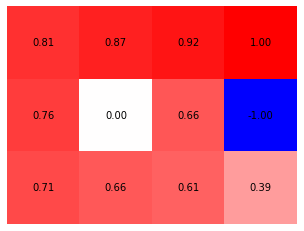

In [10]:
plot_grid_step(19)

## Q-Learning

In [23]:
computed_utility_history_q = q_learning(
    mdp=grid_mdp, alpha=0.1, epsilon=0.1, iterations=10000, return_history=True
)

In [24]:
%matplotlib inline
plot_grid_step_q = make_plot_grid_step_function(
    columns=4, rows=3, U_over_time=computed_utility_history_q
)

In [25]:
if mkdocs_flag:
    import ipywidgets
    from IPython.display import display

    iteration_slider = ipywidgets.IntSlider(
        min=0, max=len(computed_utility_history_q) - 1, step=1, value=0
    )
    w = ipywidgets.interactive(plot_grid_step_q, iteration=iteration_slider)
    display(w)

interactive(children=(IntSlider(value=0, description='iteration', max=9999), Output()), _dom_classes=('widget-…

## HIGHWAY EXAMPLE

In [26]:
if False:
    # we will change this to true later on, to see the effect
    HIGHWAY_MDP_DICT["transition_probabilities_per_action"][LC_RIGHT_ACTION] = [
        (0.4, LC_RIGHT_ACTION),
        (0.6, STAY_IN_LANE_ACTION),
    ]

In [27]:
highway_mdp = GridMDP(**HIGHWAY_MDP_DICT)

In [28]:
utility_history_highway = value_iteration(
    highway_mdp, epsilon=0.001, max_iterations=30, return_history=True
)

In [29]:
plot_grid_step_highway = make_plot_grid_step_function(
    columns=10, rows=4, U_over_time=utility_history_highway
)

In [30]:
if mkdocs_flag:
    iteration_slider = ipywidgets.IntSlider(
        min=0, max=len(utility_history_highway) - 1, step=1, value=0
    )
    w = ipywidgets.interactive(plot_grid_step_highway, iteration=iteration_slider)
    display(w)

interactive(children=(IntSlider(value=0, description='iteration', max=10), Output()), _dom_classes=('widget-in…

In [ ]:
plot_grid_step_highway(10)

In [ ]:
policy_array = [
    derive_policy(highway_mdp, utility) for utility in utility_history_highway
]

In [ ]:
plot_policy_step_highway = make_plot_policy_step_function(
    columns=10, rows=4, policy_over_time=policy_array
)

In [ ]:
if mkdocs_flag:
    iteration_slider = ipywidgets.IntSlider(
        min=0, max=len(utility_history_highway) - 1, step=1, value=0
    )
    w = ipywidgets.interactive(plot_policy_step_highway, iteration=iteration_slider)
    display(w)

In [ ]:
plot_policy_step_highway(10)

## Q-Learning

In [ ]:
utility_history_highway_q = q_learning(
    highway_mdp, alpha=0.1, epsilon=0.1, iterations=10000, return_history=True
)

In [ ]:
plot_grid_step_highway_q = make_plot_grid_step_function(
    columns=10, rows=4, U_over_time=utility_history_highway_q
)

In [ ]:
if mkdocs_flag:
    iteration_slider = ipywidgets.IntSlider(
        min=0, max=len(utility_history_highway_q) - 1, step=1, value=0
    )
    w = ipywidgets.interactive(plot_grid_step_highway_q, iteration=iteration_slider)
    display(w)